# Test

In [13]:
# Load model
from tensorflow import keras.models.load_model

# Images
import cv2 as cv
import matplotlib.pyplot as plt

import numpy as np

In [15]:
# utility.py functions
from utility import split_patches, scale_pixels, resize, crop, predict_image, calc_image_diff

## Load pretrained model

In [5]:
autoencoder = load_model("../Models/autoencoderFC")

## Dimostration of all the process step by step

Text(0.5, 1.0, 'Anomaly Located')

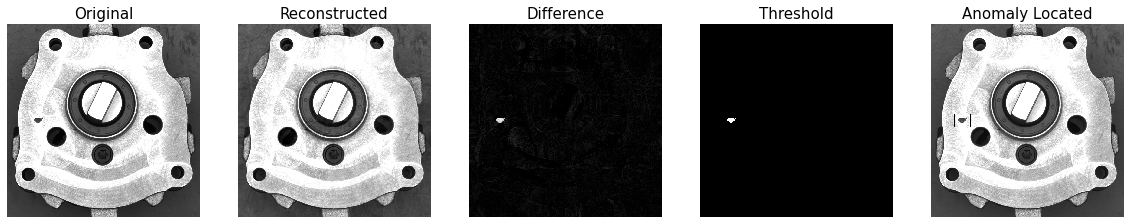

In [10]:
# ----------  Example of difference between images (code extracted from the functions used to predict that are all in the utility.py file) ---------------

# Preprocess
img = cv.imread('../Data/Prepared/Test/NOK/NOK_5.jpg', cv.IMREAD_GRAYSCALE)
img = crop(img)
img = resize(img)
img = scale_pixels(img)
slices = split_patches(img)
slices_anomal_bound = []
# Get the reconstructed images from the model
ssim_score = []
slices_rec = []
for slice in slices:
    slice_rec = autoencoder.predict(np.expand_dims(np.expand_dims(slice, 0), -1))
    slice_rec = np.squeeze(slice_rec[0], -1)
    slices_rec.append(slice_rec)
    diff, score = calc_image_diff(slice, slice_rec)
    slices_anomal_bound.append(diff)
    ssim_score.append(score)

# Mean SSIM score, to understand if the autoencoder was able to reconstruct correctly the image
ssim_score = np.mean(ssim_score)

# Reconstruct the full image processed by the autoencoder 
horizion_concat = []
for i in range(0, 16, 4):
    horizion_concat.append(cv.hconcat([slices_rec[i], slices_rec[i+1], slices_rec[i+2], slices_rec[i+3]]))
img_total_anom = cv.vconcat([horizion_concat[0], horizion_concat[1], horizion_concat[2], horizion_concat[3]])

# Reconstruct the full image difference 
horizion_concat = []
for i in range(0, 16, 4):
    horizion_concat.append(cv.hconcat([slices_anomal_bound[i], slices_anomal_bound[i+1], slices_anomal_bound[i+2], slices_anomal_bound[i+3]]))
img_total_diff = cv.vconcat([horizion_concat[0], horizion_concat[1], horizion_concat[2], horizion_concat[3]])

# Threshold to make the image only white and black (so higlight the anomalies in white)
ret, th = cv.threshold(img_total_diff, 150, 255, cv.THRESH_BINARY)
# Find the countours of the anomalies
cnts, _ = cv.findContours(th, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
# For every anomaly, draw the bounding box
anomalies_img = img.copy()
for c in cnts:
    (x, y, w, h) = cv.boundingRect(c)
    anomalies_img = cv.rectangle(anomalies_img, (x-20, y-20), (x + w + 20, y + h + 20), (0, 255, 0), 2)
    # If some anomaly is found, we classify the image as anomalous
    anomaly=True

plt.figure(figsize=(20, 20))
plt.subplot(1, 5, 1)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Original')
plt.subplot(1, 5, 2)
plt.imshow(img_total_anom, cmap='gray')
plt.axis('off')
plt.title('Reconstructed')
plt.subplot(1, 5, 3)
plt.imshow(img_total_diff, cmap='gray')
plt.axis('off')
plt.title('Difference')
plt.subplot(1, 5, 4)
plt.imshow(th, cmap='gray')
plt.axis('off')
plt.title('Threshold')
plt.subplot(1, 5, 5)
plt.imshow(anomalies_img, cmap='gray')
plt.axis('off')
plt.title('Anomaly Located')

## Model evaluation
The model evaluation is performed by computing the accuracy on the prediction of defective and not defective pieces.
The predections with a value of reconstruction score (SSIM) under 0.75 are considered not correct and require a control of the piece by an human agent.

Correctly predicted: 12
Incorrectly predicted: 1
Error in the reconstruction: 3


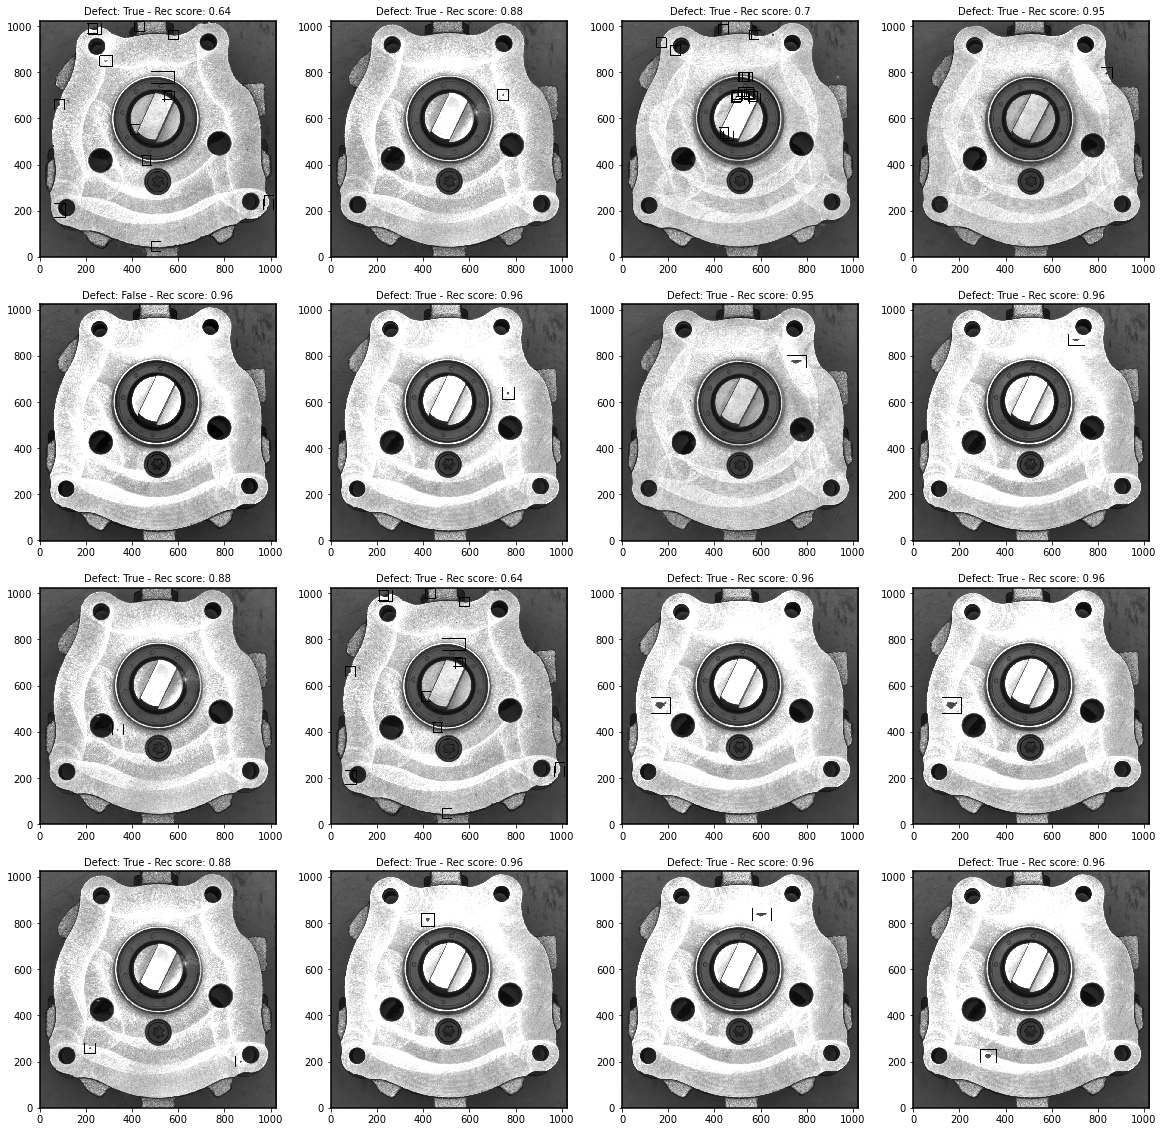

In [22]:
# Defective pieces
plt.figure(figsize=(20, 20))
correct_NOK=0
incorrect_NOK=0
error_NOK=0
i=1
for img_name in os.listdir('../Data/Prepared/Test/NOK'):
    img= cv.imread('../Data/Prepared/Test/NOK' + '/' + img_name, cv.IMREAD_GRAYSCALE)
    anom, img_anom, ssim_score = predict_image(img, autoencoder)

    # Minimum value of ssim score to understand if the image was corectly reconstructed
    if ssim_score<0.75:
        error_NOK=error_NOK+1
    else: 
        if anom==True:
            correct_NOK=correct_NOK+1
        else:
            incorrect_NOK=incorrect_NOK+1
    
    plt.subplot(4, 4, i)
    plt.title('Defect: ' + str(anom) + ' - Rec score: ' + str(round(ssim_score, 2)), fontsize=10)
    plt.imshow(img_anom, cmap='gray')
    i=i+1

print('Correctly predicted: ' + str(correct_NOK))
print('Incorrectly predicted: ' + str(incorrect_NOK))
print('Error in the reconstruction: ' + str(error_NOK))

Correctly predicted: 11
Incorrectly predicted: 0
Error in the reconstruction: 0


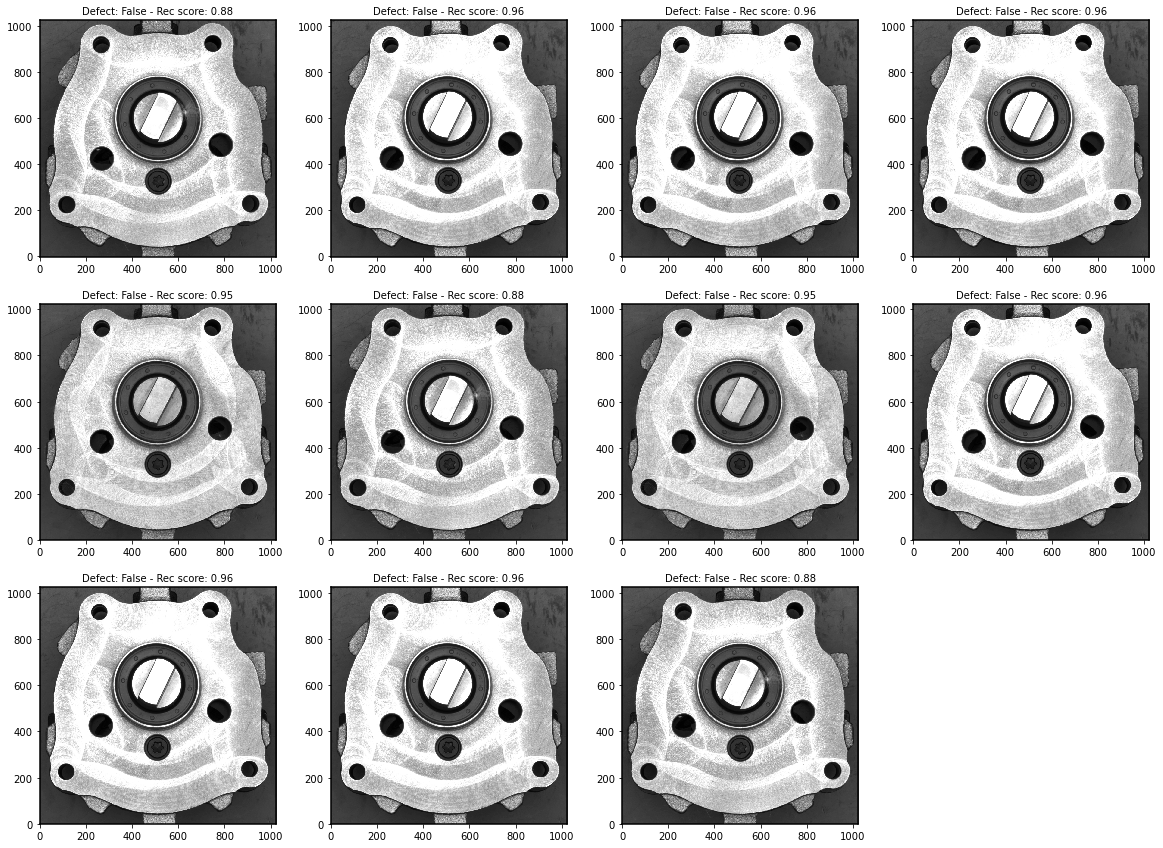

In [28]:
# Not defective pieces
plt.figure(figsize=(20, 20))
correct_OK=0
incorrect_OK=0
error_OK=0
i=1
for img_name in os.listdir('../Data/Prepared/Test/OK'):
    img= cv.imread('../Data/Prepared/Test/OK' + '/' + img_name, cv.IMREAD_GRAYSCALE)
    anom, img_anom, ssim_score = predict_image(img, autoencoder)

    # Minimum value of ssim score to understand if the image was corectly reconstructed
    if ssim_score<0.75:
        error_OK=error_OK+1
    else: 
        if anom==False:
            correct_OK=correct_OK+1
        else:
            incorrect_OK=incorrect_OK+1
    
    plt.subplot(4, 4, i)
    plt.title('Defect: ' + str(anom) + ' - Rec score: ' + str(round(ssim_score, 2)), fontsize=10)
    plt.imshow(img_anom, cmap='gray')
    i=i+1

print('Correctly predicted: ' + str(correct_OK))
print('Incorrectly predicted: ' + str(incorrect_OK))
print('Error in the reconstruction: ' + str(error_OK))

In [32]:
accuracy = (correct_OK + correct_NOK)/(correct_OK + correct_NOK + incorrect_OK + incorrect_NOK + error_OK + error_NOK)
print('Accuracy: ' + str(round(accuracy*100, 2)) + '%')

Accuracy: 85.19%


In [34]:
accuracy_valid_pred = (correct_OK + correct_NOK)/(correct_OK + correct_NOK + incorrect_OK + incorrect_NOK)
print('Accuracy of valid predictions: ' + str(round(accuracy_valid_pred*100, 2)) + '%')

Accuracy of valid predictions: 95.83%
